### Import

In [23]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr
import datetime
import geopandas as gpd

import tensorflow as tf
import cv2
# import glob
# import os

import tensorflow as tf
from keras import layers, models

In [24]:

import geemap
import ee
ee.Authenticate()
ee.Initialize(project='static-potion-450322-u2') # this is the project for Ag Genius for porter.olson11@gmail.com


### Std Dev Research

- Look at std dev across counties and across crop type
- See if we can predict yield by using std dev
- See if we can predict std dev using computer vision

#### Clean winter wheat data

In [25]:
natl=pl.read_csv(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')
natl=natl.select(['Year','State','State ANSI','County ANSI','Value','CV (%)'])

natl = natl.with_columns(
    (
        (pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
        (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3))
    ).alias('fips')
)


natl=natl.rename({'Value':'yield','CV (%)':'CV'})

natl=natl.with_columns(
    ((pl.col('CV')*pl.col('yield'))/pl.lit(100))
    .alias('std_dev')
)

In [26]:
#filter to only valid std dev obs
natl=natl.filter(
    pl.col('std_dev').is_not_null()
)
natl

Year,State,State ANSI,County ANSI,yield,CV,fips,std_dev
i64,str,i64,i64,f64,f64,str,f64
2024,"""ILLINOIS""",17,115,93.5,4.2,"""17115""",3.927
2024,"""ILLINOIS""",17,125,91.2,7.8,"""17125""",7.1136
2024,"""ILLINOIS""",17,129,91.9,1.8,"""17129""",1.6542
2024,"""ILLINOIS""",17,143,96.6,8.6,"""17143""",8.3076
2024,"""ILLINOIS""",17,203,82.6,7.4,"""17203""",6.1124
…,…,…,…,…,…,…,…
2020,"""WISCONSIN""",55,43,72.8,6.0,"""55043""",4.368
2020,"""WISCONSIN""",55,49,69.5,9.3,"""55049""",6.4635
2020,"""WISCONSIN""",55,103,54.8,4.2,"""55103""",2.3016


#### Regressions

**yield regressed on std dev**

In [27]:
import statsmodels.api as sm

y = natl['yield'].to_pandas()
X = natl['std_dev'].to_pandas()
X = sm.add_constant(X)

# Grouping variable: e.g., 'fips' or 'county'
groups = natl['fips'].to_pandas()

model = sm.OLS(y, X)
results = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  yield   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     114.2
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           1.66e-25
Time:                        12:37:38   Log-Likelihood:                -15654.
No. Observations:                3492   AIC:                         3.131e+04
Df Residuals:                    3490   BIC:                         3.132e+04
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.6488      1.100     47.868      0.0

In [28]:
#time and year fixed effects regression


from linearmodels.panel import PanelOLS

df = natl.to_pandas()
df['fips'] = df['fips'].astype(str)
df = df.set_index(['fips', 'Year'])

# Panel OLS with both county (Entity) and year (Time) fixed effects
mod = PanelOLS.from_formula('yield ~ std_dev + EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  yield   R-squared:                        0.0096
Estimator:                   PanelOLS   R-squared (Between):              0.0716
No. Observations:                3492   R-squared (Within):               0.0188
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.0676
Time:                        12:37:38   Log-likelihood                 -1.22e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      22.467
Entities:                        1177   P-value                           0.0000
Avg Obs:                       2.9669   Distribution:                  F(1,2310)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             6.6079
                            

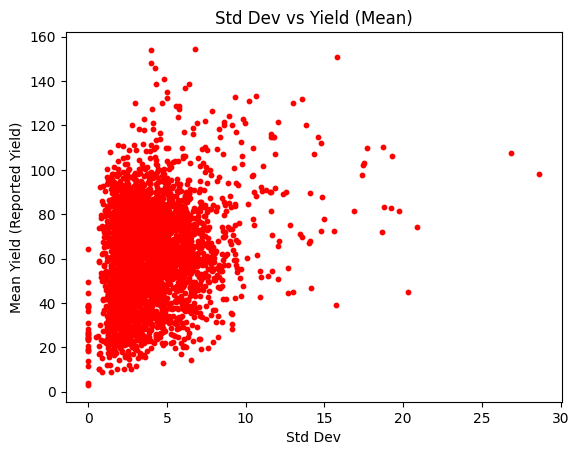

In [29]:
import matplotlib.pyplot as plt

X = natl['std_dev'].to_pandas()
plt.scatter(X,y,color='red',s=10)
plt.xlabel('Std Dev')
plt.ylabel('Mean Yield (Reported Yield)')
plt.title('Std Dev vs Yield (Mean)')
plt.show()

**predicted yield regressed on standard dev**

In [30]:
yields=pl.read_csv(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\3dcnn_v4-2.csv')
yields=yields.with_columns(
    np.abs((pl.col('yield')-pl.col('y_pred')))
    .alias('abs_error')
)
yields=yields.with_columns(
    (pl.col('yield')-pl.col('y_pred'))
    .alias('error')
)
yields=yields.with_columns(
    (pl.col('fips').cast(pl.Utf8).str.zfill(5)).alias('fips')
)
yields

,fips,Index,Year,yield,y_pred,abs_error,error
i64,str,i64,i64,f64,f64,f64,f64
4,"""40093""",0,2019,43.5,41.7765,1.7235,1.7235
32,"""30051""",1,2019,39.0,40.287403,1.287403,-1.287403
78,"""17189""",2,2019,69.4,65.68565,3.71435,3.71435
108,"""48139""",3,2019,45.5,57.219875,11.719875,-11.719875
138,"""21213""",4,2019,76.2,69.029015,7.170985,7.170985
…,…,…,…,…,…,…,…
6277,"""40129""",195,2023,30.3,48.72704,18.42704,-18.42704
6305,"""16069""",196,2023,78.0,80.07147,2.07147,-2.07147
6347,"""26063""",197,2023,105.9,82.05374,23.84626,23.84626


In [31]:
#i only have std_dev data from 2020 on, so i lose 200 obs

winter_wheat=yields.join(natl,on=['fips','Year','yield'],how='inner')
winter_wheat

,fips,Index,Year,yield,y_pred,abs_error,error,State,State ANSI,County ANSI,CV,std_dev
i64,str,i64,i64,f64,f64,f64,f64,str,i64,i64,f64,f64
1220,"""08039""",40,2023,43.7,38.561337,5.138663,5.138663,"""COLORADO""",8,39,5.0,2.185
914,"""08061""",30,2023,28.6,31.953047,3.353047,-3.353047,"""COLORADO""",8,61,7.2,2.0592
5315,"""08063""",166,2023,49.9,51.37901,1.47901,-1.47901,"""COLORADO""",8,63,5.1,2.5449
1729,"""08073""",56,2023,41.3,42.422306,1.122306,-1.122306,"""COLORADO""",8,73,15.3,6.3189
4470,"""08075""",142,2023,43.9,38.576805,5.323195,5.323195,"""COLORADO""",8,75,7.9,3.4681
…,…,…,…,…,…,…,…,…,…,…,…,…
2372,"""53071""",76,2020,86.2,82.52843,3.67157,3.67157,"""WASHINGTON""",53,71,6.2,5.3444
2417,"""53075""",77,2020,95.9,88.39513,7.50487,7.50487,"""WASHINGTON""",53,75,3.0,2.877
3535,"""55039""",112,2020,73.3,53.822117,19.477883,19.477883,"""WISCONSIN""",55,39,6.0,4.398


In [32]:
import statsmodels.api as sm

y = winter_wheat['y_pred'].to_pandas()
X = winter_wheat['std_dev'].to_pandas()
groups = winter_wheat['fips'].to_pandas()

X = sm.add_constant(X)  

model = sm.OLS(y, X)    
results = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 y_pred   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     8.845
Date:                Tue, 10 Jun 2025   Prob (F-statistic):            0.00331
Time:                        12:37:39   Log-Likelihood:                -3406.7
No. Observations:                 790   AIC:                             6817.
Df Residuals:                     788   BIC:                             6827.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1538      2.003     25.038      0.0

In [33]:
from linearmodels.panel import PanelOLS

df = winter_wheat.to_pandas()
df['fips'] = df['fips'].astype(str)
df = df.set_index(['fips', 'Year'])

# Panel OLS with both county (Entity) and year (Time) fixed effects
mod = PanelOLS.from_formula('y_pred ~ std_dev + EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                 y_pred   R-squared:                        0.0190
Estimator:                   PanelOLS   R-squared (Between):              0.0660
No. Observations:                 790   R-squared (Within):               0.0226
Date:                Tue, Jun 10 2025   R-squared (Overall):              0.0656
Time:                        12:37:39   Log-likelihood                   -2430.8
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      11.376
Entities:                         198   P-value                           0.0008
Avg Obs:                       3.9899   Distribution:                   F(1,588)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             7.4621
                            

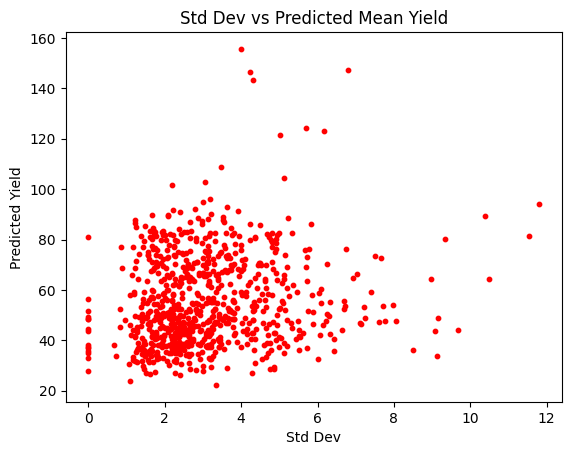

In [34]:
import matplotlib.pyplot as plt

X = winter_wheat['std_dev'].to_pandas()
plt.scatter(X,y,color='red',s=10)
plt.xlabel('Std Dev')
plt.ylabel('Predicted Yield')
plt.title('Std Dev vs Predicted Mean Yield')
plt.show()

**error regressed on standard deviation**

In [35]:
import statsmodels.api as sm

y = winter_wheat['error'].to_pandas()
X = winter_wheat['std_dev'].to_pandas()
groups = winter_wheat['fips'].to_pandas()

X = sm.add_constant(X)  

model = sm.OLS(y, X)    
results = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  error   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     11.69
Date:                Tue, 10 Jun 2025   Prob (F-statistic):           0.000762
Time:                        12:37:39   Log-Likelihood:                -3088.0
No. Observations:                 790   AIC:                             6180.
Df Residuals:                     788   BIC:                             6189.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.5860      1.116     -2.317      0.0

In [36]:
from linearmodels.panel import PanelOLS

df = winter_wheat.to_pandas()
df['fips'] = df['fips'].astype(str)
df = df.set_index(['fips', 'Year'])

# Panel OLS with both county (Entity) and year (Time) fixed effects
mod = PanelOLS.from_formula('error ~ std_dev + EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:                  error   R-squared:                        0.0589
Estimator:                   PanelOLS   R-squared (Between):             -0.3470
No. Observations:                 790   R-squared (Within):               0.0520
Date:                Tue, Jun 10 2025   R-squared (Overall):             -0.1725
Time:                        12:37:39   Log-likelihood                   -2741.2
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      36.790
Entities:                         198   P-value                           0.0000
Avg Obs:                       3.9899   Distribution:                   F(1,588)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             18.854
                            

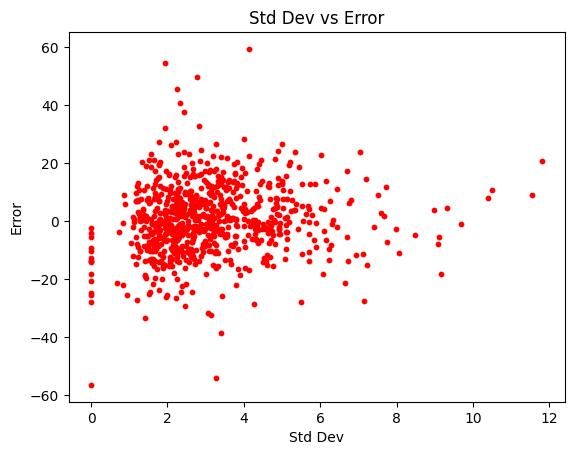

In [37]:
import matplotlib.pyplot as plt

X = winter_wheat['std_dev'].to_pandas()
plt.scatter(X,y,color='red',s=10)
plt.xlabel('Std Dev')
plt.ylabel('Error')
plt.title('Std Dev vs Error')
plt.show()

Std dev and absolute error

In [38]:
import statsmodels.api as sm

y = winter_wheat['abs_error'].to_pandas()
X = winter_wheat['std_dev'].to_pandas()
groups = winter_wheat['fips'].to_pandas()

X = sm.add_constant(X)  

model = sm.OLS(y, X)    
results = model.fit(cov_type='cluster', cov_kwds={'groups': groups})

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:              abs_error   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.012
Date:                Tue, 10 Jun 2025   Prob (F-statistic):              0.158
Time:                        12:37:39   Log-Likelihood:                -2765.0
No. Observations:                 790   AIC:                             5534.
Df Residuals:                     788   BIC:                             5543.
Df Model:                           1                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9172      0.725     13.677      0.0

In [39]:
from linearmodels.panel import PanelOLS

df = winter_wheat.to_pandas()
df['fips'] = df['fips'].astype(str)
df = df.set_index(['fips', 'Year'])

# Panel OLS with both county (Entity) and year (Time) fixed effects
mod = PanelOLS.from_formula('abs_error ~ std_dev + EntityEffects + TimeEffects', data=df)
res = mod.fit(cov_type='clustered', cluster_entity=True)

print(res.summary)


                          PanelOLS Estimation Summary                           
Dep. Variable:              abs_error   R-squared:                        0.0175
Estimator:                   PanelOLS   R-squared (Between):             -0.4131
No. Observations:                 790   R-squared (Within):               0.0061
Date:                Tue, Jun 10 2025   R-squared (Overall):             -0.3073
Time:                        12:37:39   Log-likelihood                   -2532.1
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      10.497
Entities:                         198   P-value                           0.0013
Avg Obs:                       3.9899   Distribution:                   F(1,588)
Min Obs:                       3.0000                                           
Max Obs:                       4.0000   F-statistic (robust):             3.3876
                            

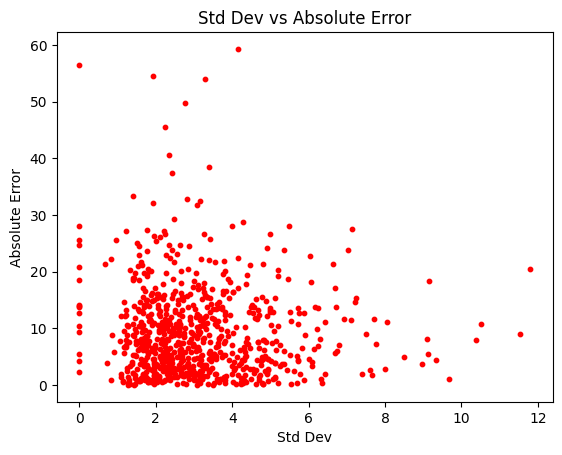

In [40]:
import matplotlib.pyplot as plt

X = winter_wheat['std_dev'].to_pandas()
plt.scatter(X,y,color='red',s=10)
plt.xlabel('Std Dev')
plt.ylabel('Absolute Error')
plt.title('Std Dev vs Absolute Error')
plt.show()

#### 3D CNN trying to predict Standard Deviation

Get y

In [17]:
y=winter_wheat['std_dev']
winter_wheat

,fips,Index,Year,yield,y_pred,abs_error,error,State,State ANSI,County ANSI,CV,std_dev
i64,str,i64,i64,f64,f64,f64,f64,str,i64,i64,f64,f64
1220,"""08039""",40,2023,43.7,38.561337,5.138663,5.138663,"""COLORADO""",8,39,5.0,2.185
914,"""08061""",30,2023,28.6,31.953047,3.353047,-3.353047,"""COLORADO""",8,61,7.2,2.0592
5315,"""08063""",166,2023,49.9,51.37901,1.47901,-1.47901,"""COLORADO""",8,63,5.1,2.5449
1729,"""08073""",56,2023,41.3,42.422306,1.122306,-1.122306,"""COLORADO""",8,73,15.3,6.3189
4470,"""08075""",142,2023,43.9,38.576805,5.323195,5.323195,"""COLORADO""",8,75,7.9,3.4681
…,…,…,…,…,…,…,…,…,…,…,…,…
2372,"""53071""",76,2020,86.2,82.52843,3.67157,3.67157,"""WASHINGTON""",53,71,6.2,5.3444
2417,"""53075""",77,2020,95.9,88.39513,7.50487,7.50487,"""WASHINGTON""",53,75,3.0,2.877
3535,"""55039""",112,2020,73.3,53.822117,19.477883,19.477883,"""WISCONSIN""",55,39,6.0,4.398


Make X and y for this CNN

In [2]:
import numpy as np
import os

data_dir = r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\modis_numpy_standardized'
X_list = []

for year_folder in sorted(os.listdir(data_dir)):
    if year_folder == "2019":
        continue

    year_path = os.path.join(data_dir, year_folder)
    if os.path.isdir(year_path):
        for fname in sorted(os.listdir(year_path)):
            if fname.endswith(".npy"):
                try:
                    # Now expecting filename like 'county_72.npy'
                    county_str = fname.replace("county_", "").replace(".npy", "")
                    county_num = int(county_str)
                except ValueError:
                    print(f"⚠️ Skipping malformed filename: {fname}")
                    continue

                if year_folder == "2022" and county_num in [72, 52]:
                    print(f"⏭️ Skipping county {county_num} in 2022")
                    continue

                full_path = os.path.join(year_path, fname)
                arr = np.load(full_path)
                X_list.append(arr)

X = np.stack(X_list, axis=0)
print("✅ Final input shape:", X.shape)


⏭️ Skipping county 52 in 2022
⏭️ Skipping county 72 in 2022
✅ Final input shape: (790, 46, 128, 128, 7)


In [4]:
np.save(file=r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_std_dev.npy',arr=X)


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=21)

In [18]:
np.save(file=r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_std_dev.npy',arr=X_train)
np.save(file=r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train_std_dev.npy',arr=y_train)
np.save(file=r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_std_dev.npy',arr=X_val)
np.save(file=r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_std_dev.npy',arr=y_val)

In [3]:
import numpy as np
import tensorflow as tf

# Load from disk using memory-mapping
X_train = np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_std_dev.npy', mmap_mode='r')
y_train = np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train_std_dev.npy', mmap_mode='r')
X_val = np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_std_dev.npy', mmap_mode='r')
y_val = np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_std_dev.npy', mmap_mode='r')
X=np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_std_dev.npy',mmap_mode='r')


In [4]:
#4.2

model = models.Sequential([
    layers.Input(shape=(46, 128, 128, 7)),
    layers.Conv3D(32, (3,3,3), activation='relu', padding='same'),
    layers.MaxPooling3D((1,2,2)),
    layers.Conv3D(64, (3,3,3), activation='relu', padding='same'),
    layers.Conv3D(128,(3,3,3),activation='relu',padding='same'),
    layers.MaxPooling3D(pool_size=(1,3,3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='linear')
])


In [5]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 46, 128, 128,   │         6,080 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 46, 64, 64, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 46, 64, 64, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 46, 64, 64,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 46, 21, 21,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2596608)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   332,365,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,648,833 (1.24 GB)

 Trainable params: 332,648,833 (1.24 GB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# 1. EarlyStopping: stop training if val_loss doesn't improve for 3 epochs
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_mse',
    patience=5,
    restore_best_weights=True
)

# 2. ModelCheckpoint: save the best model based on val_accuracy

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\models\std_dev_model.keras',               # save path
    monitor='val_mse',        # metric to monitor
    save_best_only=True,           # only save when val_accuracy improves
    save_weights_only=False,       # save entire model (not just weights)
    verbose=1                      # print when model is saved
)


In [7]:

# Define batch size
BATCH_SIZE = 32

# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE).prefetch(1)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(1)

# Fit the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - loss: 1759.9921 - mae: 17.7316 - mse: 1759.9921 
Epoch 1: val_mse improved from inf to 5.93304, saving model to C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\models\std_dev_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 724s 35s/step - loss: 1709.5800 - mae: 17.3254 - mse: 1709.5800 - val_loss: 5.9330 - val_mae: 1.9261 - val_mse: 5.9330
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - loss: 10.5389 - mae: 2.6262 - mse: 10.5389 
Epoch 2: val_mse improved from 5.93304 to 5.24054, saving model to C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\models\std_dev_model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 637s 32s/step - loss: 10.4479 - mae: 2.6130 - mse: 10.4479 - val_loss: 5.2405 - val_mae: 1.7216 - val_mse: 5.2405
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - loss: 6.8735 - mae: 2.0425 - mse: 6.8735 
Epoch 3: val_mse improved from 5.24054 to 4.93512, saving model to C:\Users\porte

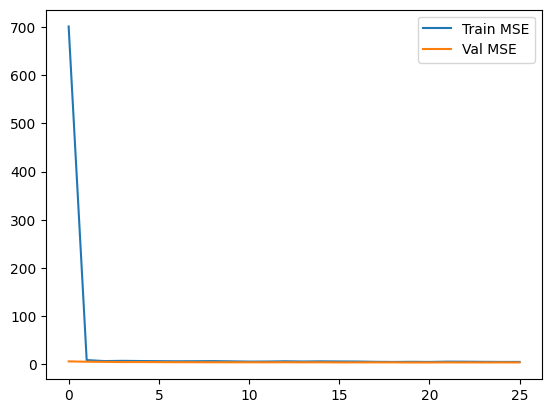

In [8]:
import matplotlib.pyplot as plt

plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.legend()
plt.show()

In [9]:
##load in X
X=np.load(r'C:\Users\porter77\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_std_dev.npy',mmap_mode='r')

y_pred=model.predict(X)

25/25 ━━━━━━━━━━━━━━━━━━━━ 126s 4s/step


In [20]:
y_pred

array([[2.6428463 ],
       [0.8107702 ],
       [2.346419  ],
       [3.209464  ],
       [1.4799706 ],
       [2.6217163 ],
       [1.9917476 ],
       [1.9560059 ],
       [2.9426248 ],
       [3.250811  ],
       [4.9885187 ],
       [1.7404113 ],
       [3.5350008 ],
       [1.9965378 ],
       [1.7499366 ],
       [2.1877244 ],
       [2.860892  ],
       [1.5754372 ],
       [1.8911768 ],
       [2.032266  ],
       [2.295392  ],
       [3.2439725 ],
       [1.7639289 ],
       [2.5082786 ],
       [1.7532052 ],
       [1.9242433 ],
       [1.1839583 ],
       [2.5100255 ],
       [2.7091033 ],
       [1.4521958 ],
       [2.6358895 ],
       [2.4200895 ],
       [2.2690105 ],
       [2.8898382 ],
       [0.9785214 ],
       [2.4096584 ],
       [1.0166681 ],
       [2.8886387 ],
       [3.2329366 ],
       [2.9416566 ],
       [0.7625136 ],
       [2.6888478 ],
       [1.0150434 ],
       [2.206719  ],
       [2.009361  ],
       [2.220791  ],
       [2.3076072 ],
       [1.747

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_true=y

# y_true = actual values
# y_pred = your model's predictions

# R²
r2 = r2_score(y_true, y_pred)

# MAE
mae = mean_absolute_error(y_true, y_pred)

# RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Print results
print(f"R²:   {r2:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


R²:   -0.1477
MAE:  1.2916
RMSE: 1.7731


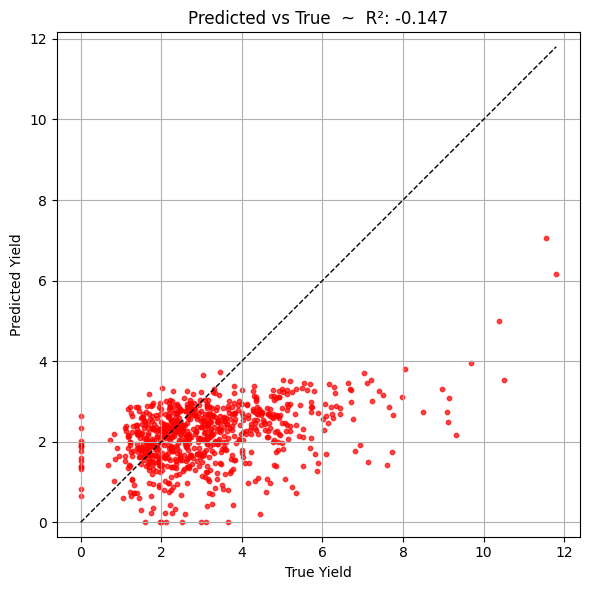

In [22]:
import matplotlib.pyplot as plt
import numpy as np


x1=y_true
y1=y_pred



plt.figure(figsize=(6, 6))
plt.scatter(x1, y1, color='red', s=10, alpha=0.7)

# Plot y = x line
min_val = min(x1.min(), y1.min())
max_val = max(x1.max(), y1.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=1, label='y = x')

plt.xlabel('True Yield')
plt.ylabel('Predicted Yield')
plt.title('Predicted vs True  ~  R²: -0.147' )
plt.grid(True)
plt.axis('equal')  # ensure square aspect ratio for fair visual comparison
plt.tight_layout()
plt.show()
